In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. 데이터 불러오기(상관분석 X)

In [2]:
df_filtered=pd.read_excel('데이터2_독립변수전체_최종_24추가.xlsx')

df_filtered

,판매일,판매수량,가공식품류,경제성장률(실질GDP성장률),기준금리,기타잡화,남성 실업률,빵.케익.과자류,생활물가지수,생활잡화,소비자물가지수,소비자심리지수,여성 실업률,"음료,차류",일상용품,전체 실업률,조미료류,총 발주건수,평균 발주 일자
0,2021-01-01,4,0.0,2.5,0.5,0.0,5.0,0.00,101.20,0.0,101.04,95.3,6.7,0.000000,0.0,5.7,0.0,44.000000,24.600000
1,2021-01-05,2885,0.0,2.5,0.5,0.0,5.0,0.00,101.20,0.0,101.04,95.3,6.7,0.000000,0.0,5.7,0.0,35.000000,53.073554
2,2021-01-12,77,0.0,2.5,0.5,0.0,5.0,0.75,101.20,0.0,101.04,95.3,6.7,0.500000,0.5,5.7,0.0,35.375000,37.087500
3,2021-01-19,474,0.0,2.5,0.5,0.0,5.0,0.00,101.20,0.0,101.04,95.3,6.7,0.000000,0.0,5.7,0.0,38.636364,25.990909
4,2021-01-26,1057,0.0,2.5,0.5,0.0,5.0,0.00,101.20,0.0,101.04,95.3,6.7,0.000000,0.0,5.7,0.0,33.818182,29.174545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2024-05-28 00:00:00,1689,0.0,2.3,3.5,0.0,3.1,0.00,116.62,0.0,114.10,98.4,2.7,0.526316,0.0,3.0,0.0,41.039216,27.850980
219,2024-06-04 00:00:00,1453,0.0,2.3,3.5,0.0,3.0,0.00,116.62,0.0,113.84,100.9,2.8,0.000000,0.0,2.9,0.0,38.166667,29.332407
220,2024-06-11 00:00:00,1010,0.0,2.3,3.5,0.0,3.0,0.00,116.62,0.0,113.84,100.9,2.8,0.573770,0.0,2.9,0.0,41.600000,27.209000
221,2024-06-18 00:00:00,937,0.0,2.3,3.5,0.0,3.0,0.00,116.62,0.0,113.84,100.9,2.8,0.000000,0.0,2.9,0.0,42.325843,22.784270


In [3]:
#데이터셋 변수 확인
print(df_filtered.columns.tolist())

['판매일', '판매수량', '가공식품류', '경제성장률(실질GDP성장률)', '기준금리', '기타잡화', '남성 실업률', '빵.케익.과자류', '생활물가지수', '생활잡화', '소비자물가지수', '소비자심리지수', '여성 실업률', '음료,차류', '일상용품', '전체 실업률', '조미료류', '총 발주건수', '평균 발주 일자']


## 2. 변수 설정 및 스케일링

In [4]:
# 판매일 인덱스 처리
df = df_filtered.copy()
df['판매일'] = pd.to_datetime(df['판매일'])

df.set_index('판매일', inplace=True)

# 독립변수, 종속 변수 지정
X = df.drop(columns=['판매수량'])
y = df['판매수량']

# 독립변수 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## 3. 시퀀스 데이터 생성 및 데이터 분할

In [5]:
# 시계열 데이터 예측을 위한 생성 함수
def create_sequences(X, y, time_steps=4):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 시퀀스 데이터 생성 (4주 단위)
time_steps = 4
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps)

In [6]:
# 학습 데이터와 테스트 데이터 분리 (2024년 1월 이전까지는 학습, 이후는 테스트)
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

## 4. 모델 함수 생성

In [7]:
# LSTM 모델 구축
def build_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# GRU 모델 구축
def build_gru_model(units=50):
    model = Sequential()
    model.add(GRU(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

## 5. 모델 학습 및 성능 평가

In [8]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return y_pred, rmse, mae

# LSTM 모델 학습 및 평가
lstm_model = build_lstm_model()
y_pred_lstm, rmse_lstm, mae_lstm = train_and_evaluate_model(lstm_model, X_train, y_train, X_test, y_test)

# GRU 모델 학습 및 평가
gru_model = build_gru_model()
y_pred_gru, rmse_gru, mae_gru = train_and_evaluate_model(gru_model, X_train, y_train, X_test, y_test)

print(f"LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}")
print(f"GRU RMSE: {rmse_gru}, MAE: {mae_gru}")

/Users/kook/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/kook/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LSTM RMSE: 746.75409847957, MAE: 642.9711303710938
GRU RMSE: 702.3774340558903, MAE: 595.32504827326


## 6. 마무리

In [13]:
# 판매일 인덱스 생성
pred_dates = df.index[-len(y_test):]  # 테스트 데이터의 판매일 인덱스

# 실제값, LSTM 예측값, GRU 예측값으로 데이터프레임 생성
results = pd.DataFrame({
    '판매일': pred_dates,
    '실제값': y_test,
    'GRU 예측값': y_pred_gru.flatten(),
    'LSTM 예측값': y_pred_lstm.flatten()    # 1D 배열로 변환
})

# 인덱스를 판매일로 설정
results.set_index('판매일', inplace=True)

# 결과 데이터프레임 출력
results

,실제값,GRU 예측값,LSTM 예측값
판매일,,,
2023-08-29,1612,1044.027466,1048.328735
2023-09-05,2033,1018.879761,1065.857300
2023-09-12,2059,1116.444946,1151.244385
2023-09-19,1542,1097.068481,1124.852905
2023-09-26,760,1095.273071,1117.689087
2023-10-03,1503,1121.001953,1158.086182
2023-10-10,1548,1070.546265,1128.218262
2023-10-17,1748,1124.410278,1129.232544
2023-10-24,2195,1020.959412,971.902344


In [14]:
results = results.reset_index()

results

,판매일,실제값,GRU 예측값,LSTM 예측값
0,2023-08-29,1612,1044.027466,1048.328735
1,2023-09-05,2033,1018.879761,1065.857300
2,2023-09-12,2059,1116.444946,1151.244385
3,2023-09-19,1542,1097.068481,1124.852905
4,2023-09-26,760,1095.273071,1117.689087
5,2023-10-03,1503,1121.001953,1158.086182
6,2023-10-10,1548,1070.546265,1128.218262
7,2023-10-17,1748,1124.410278,1129.232544
8,2023-10-24,2195,1020.959412,971.902344
9,2023-10-31,2051,1069.568359,1079.819580


In [18]:
# 2024년도 데이터만 필터링
results_2024 = results[results['판매일'].dt.year == 2024]

# 월별로 그룹화하고 합산
monthly_sales = results_2024.resample('M', on='판매일').sum().reset_index()

# 'index' 칼럼 삭제
monthly_sales = monthly_sales.drop(columns=['index'], errors='ignore')

monthly_sales

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_6179/2854464769.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = results_2024.resample('M', on='판매일').sum().reset_index()


,판매일,실제값,GRU 예측값,LSTM 예측값
0,2024-01-31,3859,6087.492676,6690.575684
1,2024-02-29,3146,4911.905762,5702.192383
2,2024-03-31,2385,4798.817383,5469.315430
3,2024-04-30,5231,5930.996582,6633.763184
4,2024-05-31,3432,4704.814453,5203.310547
5,2024-06-30,4687,4992.263672,5669.668945


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_6179/620690812.py:17: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_6179/620690812.py:17: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_6179/620690812.py:17: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

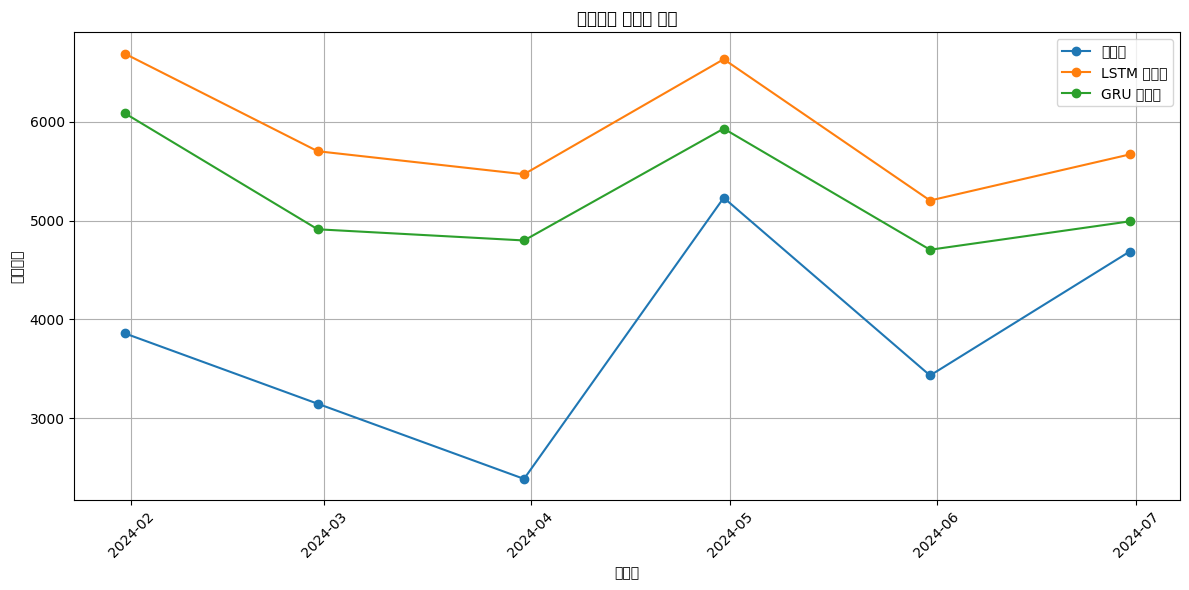

In [12]:
import matplotlib.font_manager as fm

plt.rc('font', family='Malgun Gothic')

#라인 차트 시각화
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['판매일'], monthly_sales['실제값'], marker='o', label='실제값')
plt.plot(monthly_sales['판매일'], monthly_sales['LSTM 예측값'], marker='o', label='LSTM 예측값')
plt.plot(monthly_sales['판매일'], monthly_sales['GRU 예측값'], marker='o', label='GRU 예측값')

plt.title('실제값과 예측값 비교')
plt.xlabel('판매일')
plt.ylabel('판매수량')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()